We first define a timer to record the time taken for the diffusion process with different methods (pure python, Numba acceleration, parallelisation, ...). 
The measured time is used to compare their performance in the reminder of this report.

In [1]:
import time

class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [2]:
import numpy as np

def diffusion_iteration(un):
    """
    Perform one diffusion step for all given grid points.
    
    Parameters
    ----------
    un : numpy.ndarray
        Numpy array of type `float64` and dimension (N + 2, N + 2) that stores the
        function values at step n.
        
    This function returns a Numpy array of dimension (N + 2, N + 2) of type `float64`
    that contains the function values after performing one step of the above diffusion
    iteration.
    """
    #initialization
    res = np.empty(un.shape)

    for irow in range(un.shape[0]):
        for icol in range(un.shape[1]):
            #for points at boundaries keep their values fixed
            if irow == 0 or icol == 0 or irow == un.shape[0] - 1 or icol == un.shape[1] - 1:
                res[irow][icol] = un[irow][icol]
            #else take the average of adjacent points                
            else:
                res[irow][icol] = (un[irow + 1][icol] + un[irow - 1][icol] + un[irow][icol + 1] + un[irow][icol - 1]) / 4

    return res


The average of adjacents points of a discrete point will take 4 steps and there will be N^2 points, expect the boundaries, need to be evaluated in a square grid. Therefore, we expect a time compliexity of O(N^2).

In order to collect enough results to verify our estimation of the time compliexity while keep the runtime within a reasonable period, we test for grid size N = 10, 50, 100, 200, ..., 1000. And then plot the runtime against grid.

Time for [10, 10] grid with method pure per iteration: 0.0009963512420654297
Time for [50, 50] grid with method pure per iteration: 0.003975629806518555
Time for [100, 100] grid with method pure per iteration: 0.01699995994567871
Time for [200, 200] grid with method pure per iteration: 0.07097673416137695
Time for [300, 300] grid with method pure per iteration: 0.16702890396118164
Time for [400, 400] grid with method pure per iteration: 0.2999992370605469
Time for [500, 500] grid with method pure per iteration: 0.4610111713409424
Time for [600, 600] grid with method pure per iteration: 0.6590008735656738
Time for [700, 700] grid with method pure per iteration: 0.9049668312072754
Time for [800, 800] grid with method pure per iteration: 1.1640300750732422
Time for [900, 900] grid with method pure per iteration: 1.5199999809265137
Time for [1000, 1000] grid with method pure per iteration: 1.8459997177124023


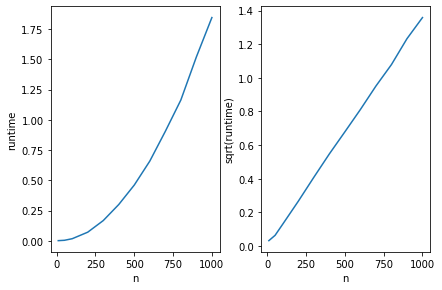

In [3]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(0) # to avoid the potential influence of different starting points
grid_size = [10, 50] + [i for i in range(100, 1001, 100)]
rec_pure = np.empty(0) # record the performance

for num in grid_size:
    ini_distribution = np.random.rand(num, num).astype("float64")
    with Timer() as t:
        diffusion_iteration(ini_distribution)
    print("Time for [{grid_size}, {grid_size}] grid with method {method} per iteration: {time}".format(grid_size=num, method = "pure", time = t.interval))

    rec_pure = np.append(rec_pure, t.interval)

#pl
fig, axs = plt.subplots(1, 2)
fig.tight_layout()
axs[0].plot(grid_size, rec_pure)
axs[0].set_xlabel("n")
axs[0].set_ylabel("runtime")
axs[1].plot(grid_size, np.sqrt(rec_pure))
axs[1].set_xlabel("n")
axs[1].set_ylabel("sqrt(runtime)")
plt.show()

The two figures above show how runtime changing with the grid size n. The clear linearity in the right figure, sqrt(runtime) against n, provides evidence for our previous O(N^2) estimation. We notice there is a short non-linear relationship at the lower end when n is small might. It might result from the fact that when n is small the cost of floating points operations is not the major part compared to the initialisation and I/O process.

In this case where the floating points operation is simple and takes the major part of the runtime, the runtime can easily grow beyond hours when N > 10E5, according to a O(N^2) complexity, which will certainly limit its usage in real usercase.

We can improve it by appliying Numba and parallelise the function.

In [4]:
import numpy as np
from numba import njit

@njit
def diffusion_iteration_njit(un):
    #initialization
    res = np.empty(un.shape)

    for irow in range(un.shape[0]):
        for icol in range(un.shape[1]):
            #for points at boundaries keep their values fixed
            if irow == 0 or icol == 0 or irow == un.shape[0] - 1 or icol == un.shape[1] - 1:
                res[irow][icol] = un[irow][icol]
            #else take the average of adjacent points
            else:

                res[irow][icol] = (un[irow + 1][icol] + un[irow - 1][icol] + un[irow][icol + 1] + un[irow][icol - 1]) / 4
              
    return res

Technically the jit mode could be a safer alternative since it allows Numba to choose where to optimize. However, in this simple case, njit methods did not show a noticeable difference in early attempts. We simply illustrate the njit methods here for the purpose of clearity.

Time for [10, 10] grid with method pure per iteration: 0.3750278949737549
Time for [50, 50] grid with method pure per iteration: 0.0
Time for [100, 100] grid with method pure per iteration: 0.0
Time for [500, 500] grid with method pure per iteration: 0.0
Time for [1000, 1000] grid with method pure per iteration: 0.0029997825622558594
Time for [2000, 2000] grid with method pure per iteration: 0.011968374252319336
Time for [5000, 5000] grid with method pure per iteration: 0.08099937438964844
Time for [10000, 10000] grid with method pure per iteration: 0.330000638961792
Time for [20000, 20000] grid with method pure per iteration: 1.2599718570709229


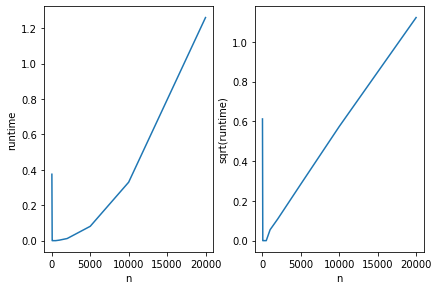

In [5]:
grid_size = [10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000]

method = "njit"
np.random.seed(0)
rec_njit = np.empty(0)
for num in grid_size:
    ini_distribution = np.random.rand(num, num).astype("float64")
    with Timer() as t:
        diffusion_iteration_njit(ini_distribution)
    print("Time for [{grid_size}, {grid_size}] grid with method {method} per iteration: {time}".format(grid_size=num, method = "pure", time = t.interval))

    rec_njit = np.append(rec_njit, t.interval)

#plotting
fig, axs = plt.subplots(1, 2)
fig.tight_layout()
axs[0].plot(grid_size, rec_njit)
axs[0].set_xlabel("n")
axs[0].set_ylabel("runtime")
axs[1].plot(grid_size, np.sqrt(rec_njit))
axs[1].set_xlabel("n")
axs[1].set_ylabel("sqrt(runtime)")
plt.show()

Numba library turns python code into low-level machine code to avoid the performance limitation of GIL of python interpreter.
We run the performance for grid size N = 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000. It is noticeable that the runtime for the first attempt after define the function is unexpected long compared to later ones. To avoid this unknown feature, I choose to run the exact code again in the following cell.

Time for [10, 10] grid with method njit per iteration: 0.0
Time for [50, 50] grid with method njit per iteration: 0.0
Time for [100, 100] grid with method njit per iteration: 0.0
Time for [500, 500] grid with method njit per iteration: 0.0009992122650146484
Time for [1000, 1000] grid with method njit per iteration: 0.003998517990112305
Time for [2000, 2000] grid with method njit per iteration: 0.012997627258300781
Time for [5000, 5000] grid with method njit per iteration: 0.0799705982208252
Time for [10000, 10000] grid with method njit per iteration: 0.3290219306945801
Time for [20000, 20000] grid with method njit per iteration: 1.2369987964630127


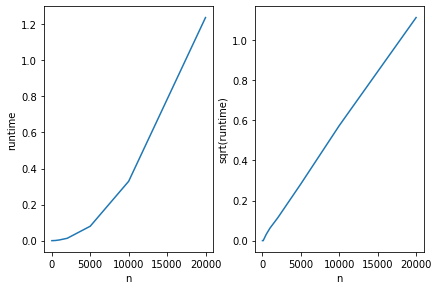

In [6]:
grid_size = [10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000]

method = "njit"
np.random.seed(0)
rec_njit = np.empty(0)
for num in grid_size:
    ini_distribution = np.random.rand(num, num).astype("float64")
    with Timer() as t:
        diffusion_iteration_njit(ini_distribution)
    print("Time for [{grid_size}, {grid_size}] grid with method {method} per iteration: {time}".format(grid_size=num, method = method, time = t.interval))

    rec_njit = np.append(rec_njit, t.interval)

#plotting
fig, axs = plt.subplots(1, 2)
fig.tight_layout()
axs[0].plot(grid_size, rec_njit)
axs[0].set_xlabel("n")
axs[0].set_ylabel("runtime")
axs[1].plot(grid_size, np.sqrt(rec_njit))
axs[1].set_xlabel("n")
axs[1].set_ylabel("sqrt(runtime)")
plt.show()

For the case N = 500, runtime decreases from 0.45 to 0.0001 seconds. For the case n = 1000, it decreases from 1.8 to 0.003 seconds.
Numba accelerates the diffusion process about 450 times for the each cases. As we expected earlier, for large N, the sqrt(runtime) remains a linear relationship against N. 

The performance could be improved further by implement the parallel feature of Numba. Such feature optimizes the for-loops in origional function and allows multiple trends to deliver better performance on multicore CPUs. We could simple replace the range to numba.prange to active such feature.

As the calculation for each points over the grid is completely decoupled, multitrending process could theoretically speed up the code by multiple times, depends on our threads setting and physical CPU cores. In the following case, we set the number of threads to 4. The estimate performance improvement should be 4 times.

In [7]:
import numpy as np
import numba
from numba import njit, prange
numba.config.NUMBA_DEFAULT_NUM_THREADS = 4

@njit(parallel=True)
def diffusion_iteration_njit_par(un):

    #initialization
    res = np.empty(un.shape)
    #change range to prange to let numba know where to optimize
    for irow in prange(un.shape[0]):
        #the prange function is only applied to the outer for-loop to aviod nested parallelisation 
        for icol in range(un.shape[1]):
            #for points at boundaries keep their values fixed
            if irow == 0 or icol == 0 or irow == un.shape[0] - 1 or icol == un.shape[1] - 1:
                res[irow][icol] = un[irow][icol]
            else:
                #else take the average of adjacent points
                res[irow][icol] = (un[irow + 1][icol] + un[irow - 1][icol] + un[irow][icol + 1] + un[irow][icol - 1]) / 4
     
    return res

Time for [10, 10] grid with method njit_parallel per iteration: 0.7689709663391113
Time for [50, 50] grid with method njit_parallel per iteration: 0.0
Time for [100, 100] grid with method njit_parallel per iteration: 0.0
Time for [500, 500] grid with method njit_parallel per iteration: 0.0
Time for [1000, 1000] grid with method njit_parallel per iteration: 0.0010051727294921875
Time for [2000, 2000] grid with method njit_parallel per iteration: 0.005967140197753906
Time for [5000, 5000] grid with method njit_parallel per iteration: 0.03999781608581543
Time for [10000, 10000] grid with method njit_parallel per iteration: 0.19299888610839844
Time for [20000, 20000] grid with method njit_parallel per iteration: 0.7300319671630859


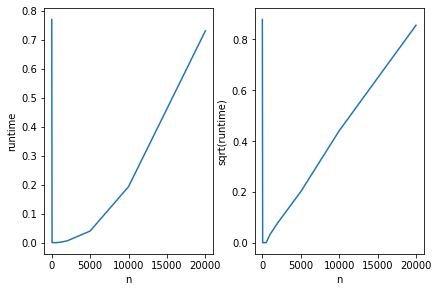

In [8]:

method = "njit_parallel"
np.random.seed(0)
rec_njit_par = np.empty(0)
for num in grid_size:
    ini_distribution = np.random.rand(num, num).astype("float64")
    with Timer() as t:
        diffusion_iteration_njit_par(ini_distribution)
    print("Time for [{grid_size}, {grid_size}] grid with method {method} per iteration: {time}".format(grid_size=num, method = method, time = t.interval))

    rec_njit_par = np.append(rec_njit_par, t.interval)

#plotting
fig, axs = plt.subplots(1, 2)
fig.tight_layout()
axs[0].plot(grid_size, rec_njit_par)
axs[0].set_xlabel("n")
axs[0].set_ylabel("runtime")
axs[1].plot(grid_size, np.sqrt(rec_njit_par))
axs[1].set_xlabel("n")
axs[1].set_ylabel("sqrt(runtime)")
plt.show()

The unexpected long first-time runtime still occurs. Therefore, the same code is run for an extra time.

Time for [10, 10] grid with method njit_parallel per iteration: 0.0
Time for [50, 50] grid with method njit_parallel per iteration: 0.0010013580322265625
Time for [100, 100] grid with method njit_parallel per iteration: 0.0
Time for [500, 500] grid with method njit_parallel per iteration: 0.0009992122650146484
Time for [1000, 1000] grid with method njit_parallel per iteration: 0.0020003318786621094
Time for [2000, 2000] grid with method njit_parallel per iteration: 0.006999969482421875
Time for [5000, 5000] grid with method njit_parallel per iteration: 0.040971994400024414
Time for [10000, 10000] grid with method njit_parallel per iteration: 0.16199970245361328
Time for [20000, 20000] grid with method njit_parallel per iteration: 0.7350294589996338


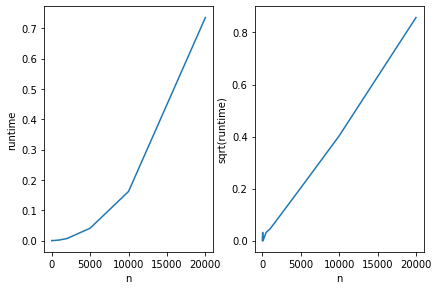

In [9]:
method = "njit_parallel"
np.random.seed(0)
rec_njit_par = np.empty(0)
for num in grid_size:
    ini_distribution = np.random.rand(num, num).astype("float64")
    with Timer() as t:
        diffusion_iteration_njit_par(ini_distribution)
    print("Time for [{grid_size}, {grid_size}] grid with method {method} per iteration: {time}".format(grid_size=num, method = method, time = t.interval))

    rec_njit_par = np.append(rec_njit_par, t.interval)

#plotting
fig, axs = plt.subplots(1, 2)
fig.tight_layout()
axs[0].plot(grid_size, rec_njit_par)
axs[0].set_xlabel("n")
axs[0].set_ylabel("runtime")
axs[1].plot(grid_size, np.sqrt(rec_njit_par))
axs[1].set_xlabel("n")
axs[1].set_ylabel("sqrt(runtime)")
plt.show()

There is a roughly 900 times increase for the case N = 1000 compared to pure python code. And the increase is 50%, 0.003 to 0.002 compared to numba method without parallelisation.

The 50% increase in the performance compared to unparallelisation method is lower than our previous expectation 4 times. It may result from the fact that the cost of creating multiple threads has negative impacts on the performance.

To have a preliminary estimitation of the performance increase by parallelisation, we compare the runtime for parallel and unparallel case.

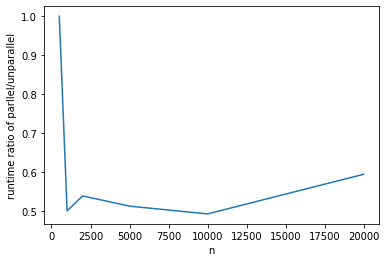

In [10]:
plt.plot(grid_size, rec_njit_par/rec_njit)
plt.xlabel("n")
plt.ylabel("runtime ratio of parllel/unparallel")
plt.show()

For N > 2000, the parallelisation method has a 50% improvement between 40-50% compared to direct numba implementation.

The following part aims to visulize the process of the diffusion.

We begins our setup a pratical case by a cooling metal. Imagine a piece of metal is heated by a laser external source at its middle. Then remove the laser and let our metal start cooling down. The centre of the gird should be some finite value and we set the boundaries to be 0 degree.

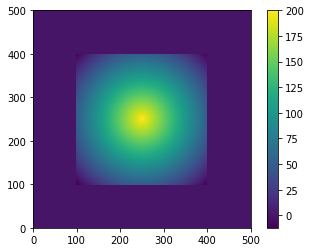

In [11]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fps = 30
n_seconds = 8

# we set the grid size = 500 and the highest temperature of  row and col with index (100: 400) is set to be 200 and decay linearly
# actually the heat distribution could be more precise if Boltzmanm or normal distribution
grid_size_vis = 500
ini_distribution = np.zeros((grid_size_vis, grid_size_vis))
for irow in range(100, 400):
    for icol in range(100, 400):
        ini_distribution[irow][icol] = 200 - np.sqrt(abs((irow-250))**2 + abs(icol - 250)**2)

temp = ini_distribution.copy()

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 500), ylim=(0, 500))
im = plt.imshow(ini_distribution,interpolation='none')
fig.colorbar(im)

# initialization function: plot the background of each frame
def init():
    im.set_data(ini_distribution)
    return [im]

# animation function.  This is called sequentially
def animate(i):
    temp = im.get_array()
    temp = diffusion_iteration_njit_par(temp)   
    im.set_array(temp)
    return [im]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=fps*n_seconds, interval=1000/fps, blit=True)

plt.show()

The above code is expected to produce a 8 seconds long animation of how the heat diffusing from the centre to the surrounding. The yellow part represents the heated part of the metal while the purple part is initially set to be 0 degree.

However, as the jupyter notebook does not support interactive graph, the animation may not work in a jupyter notebook. It is also necessary to replace the %matplotlib inline to %matplotlib notebook for better illustration.

In case there is a set of inner of indices which are also fixed during the diffusion process. We should introduce an additional parameter constant_indices to our diffusion function. 

We use a list of index [[idx_x1, index_y1], [idx_x2, index_y2], ...] to represent the indices of fixed value points.
The most intuitive implementation, which has been used in the following part, is to add an extra for-loop to set all the fixed value points to its original value. It is not the most space and time efficient implementation but perfectly fits the principle of parallelization.

In [12]:
import numpy as np
import numba
from numba import njit, prange
numba.config.NUMBA_DEFAULT_NUM_THREADS = 4

@njit(parallel=True)
def diffusion_iteration_njit_par_fix(un, constant_indices=[]):

    #initialization
    res = np.empty(un.shape)
    #change range to prange to let numba know where to optimize
    for irow in prange(un.shape[0]):
        #the prange function is only applied to the outer for-loop to aviod nested parallelisation 
        for icol in range(un.shape[1]):
            #for points at boundaries keep their values fixed
            if irow == 0 or icol == 0 or irow == un.shape[0] - 1 or icol == un.shape[1] - 1:
                res[irow][icol] = un[irow][icol]
            else:
                #else take the average of adjacent points
                res[irow][icol] = (un[irow + 1][icol] + un[irow - 1][icol] + un[irow][icol + 1] + un[irow][icol - 1]) / 4
     
    for idx in constant_indices:
         res[idx[0]][idx[1]] = un[idx[0]][idx[1]]

    return res

We test the new diffusion function by applying equally separated fixed points boundary condition.

In [13]:
idx_fix = []
#the index of fixed points are separated by 10 unit an spread uniformly over the grid.
for i in range(0, 500, 10):
    for j in range(0, 500, 10):
        idx_fix.append([i, j])

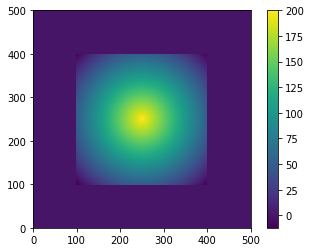

In [14]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fps = 30
n_seconds = 8

# we set the grid size = 500 and the highest temperature of  row and col with index (100: 400) is set to be 200 and decay linearly
# actually the heat distribution could be more precise if Boltzmanm or normal distribution
grid_size_vis = 500
ini_distribution = np.zeros((grid_size_vis, grid_size_vis))
for irow in range(100, 400):
    for icol in range(100, 400):
        ini_distribution[irow][icol] = 200 - np.sqrt(abs((irow-250))**2 + abs(icol - 250)**2)

temp = ini_distribution.copy()

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 500), ylim=(0, 500))
im = plt.imshow(ini_distribution,interpolation='none')
fig.colorbar(im)

# initialization function: plot the background of each frame
def init():
    im.set_data(ini_distribution)
    return [im]

# animation function.  This is called sequentially
def animate(i):
    temp = im.get_array()
    temp = diffusion_iteration_njit_par_fix(temp, idx_fix)   
    im.set_array(temp)
    return [im]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=fps*n_seconds, interval=1000/fps, blit=True)

plt.show()